<a href="https://colab.research.google.com/github/SurekhaBerlin/British-Airways-Data-Science-Project/blob/main/BritishAirwaysProjectTask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## STEP 0: Importing libraries

In [58]:
# Standard Libraries

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# For visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


# For Web Scrapping
import requests
from bs4 import BeautifulSoup

# For Data Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from textblob import Word, TextBlob
from wordcloud import WordCloud , STOPWORDS

# For topic modeling
from sklearn.decomposition import NMF, LatentDirichletAllocation



In [59]:
import nltk

"""This punkt tokenizer divides a text into a list of sentences by using an unsupervised algorithm to build a model for abbreviation words,
collocations, and words that start sentences. """

nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk import pos_tag
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## STEP 1: Extracting reviews from "Skytrax" website

In [46]:

# URL of the website to scrape
website = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10  # Total number of pages to scrape
page_size = 100  # Number of reviews per page

# List to store extracted reviews
reviews = []

for i in range(1, pages + 1):
    print(f"Scraping data from Page {i}")

    # Create URL to collect links from the current page
    url = f"{website}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    try:
        # Send a request to fetch the HTML content of the page
        response = requests.get(url)
        response.raise_for_status()  # Check if the request was successful

        # Parse the HTML content
        content = response.content
        parsed_content = BeautifulSoup(content, 'html.parser')

        # Extract reviews from the HTML content
        reviews_on_page = parsed_content.find_all("div", {"class": "text_content"})
        if not reviews_on_page:
            print("   ---> No reviews found on this page")
            break  # Exit if no reviews are found

        for review in reviews_on_page:
            reviews.append(review.get_text())

        print(f"   ---> {len(reviews)} Total Reviews")



    except requests.RequestException as e:
        print(f"   Error scraping page {i}: {e}")
        break  # Exit the loop if an error occurs

print(f"Scraping completed. Total reviews collected: {len(reviews)}")


Scraping data from Page 1
   ---> 100 Total Reviews
Scraping data from Page 2
   ---> 200 Total Reviews
Scraping data from Page 3
   ---> 300 Total Reviews
Scraping data from Page 4
   ---> 400 Total Reviews
Scraping data from Page 5
   ---> 500 Total Reviews
Scraping data from Page 6
   ---> 600 Total Reviews
Scraping data from Page 7
   ---> 700 Total Reviews
Scraping data from Page 8
   ---> 800 Total Reviews
Scraping data from Page 9
   ---> 900 Total Reviews
Scraping data from Page 10
   ---> 1000 Total Reviews
Scraping completed. Total reviews collected: 1000


In [47]:
# Storing reviews in a pandas dataframe
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | If you can’t fly First Class...
1,Not Verified | Singapore to Heathrow. Busine...
2,Not Verified | I reported my damaged/ruined ...
3,"Not Verified | On March 1st, I flew from Ber..."
4,Not Verified | The WORST customer experience! ...


## Findings:

1. We have collected the data required for this task from "Skytrax" website

2. There are 3825 reviews by iterating through 50 pages on the website.

3. Next step is to clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed wherever it exists as it's not relevant or any special characters etc.

## STEP 2: Data Processing

Rule-based approach

This is a practical approach to analyzing text without training or using machine learning models. The result of this approach is a set of rules based on which the text is labeled as positive/negative/neutral. These rules are also known as lexicons. Hence, the Rule-based approach is called Lexicon based approach.

Widely used lexicon-based approaches are TextBlob, VADER, SentiWordNet.

Data preprocessing steps:

1. Removing the parts before | in the reviews column

2. Cleaning the text

3. Tokenization

4. Regular Expressions

5. Converting into Lower Case

6. Removing Punctuations

7. Removing Numbers

8. Stopwords removal

9. Lemmatization

10. POS Tagging

### 1. Removing the parts before | in the reviews column

In [48]:
df.reviews= df.reviews.str.split('|',expand=True)[1]
df.head()

,reviews
0,If you can’t fly First Class don’t fly Britis...
1,Singapore to Heathrow. Business class on an...
2,I reported my damaged/ruined suitcase 5 wee...
3,"On March 1st, I flew from Berlin to São Pau..."
4,The WORST customer experience! British Airway...


### 2. Cleaning the text

In [49]:
import re

# Define a function to clean the text
def clean(text):
# Removes all special characters and numericals leaving the alphabets
    text = re.sub('[^A-Za-z]+', ' ', str(text))
    return text

# Cleaning the text in the review column
df['Cleaned Reviews'] = df['reviews'].apply(clean)
df.head()

,reviews,Cleaned Reviews
0,If you can’t fly First Class don’t fly Britis...,If you can t fly First Class don t fly Britis...
1,Singapore to Heathrow. Business class on an...,Singapore to Heathrow Business class on an A ...
2,I reported my damaged/ruined suitcase 5 wee...,I reported my damaged ruined suitcase weeks a...
3,"On March 1st, I flew from Berlin to São Pau...",On March st I flew from Berlin to S o Paulo w...
4,The WORST customer experience! British Airway...,The WORST customer experience British Airways...


### 3. Tokenization

Tokenization is the process of breaking the text into smaller pieces called Tokens. It can be performed at sentences(sentence tokenization) or word level(word tokenization).

In [50]:
df["reviews"].apply(lambda x: TextBlob(x).words).head()

0    [If, you, can, ’, t, fly, First, Class, don, ’...
1    [Singapore, to, Heathrow, Business, class, on,...
2    [I, reported, my, damaged/ruined, suitcase, 5,...
3    [On, March, 1st, I, flew, from, Berlin, to, Sã...
4    [The, WORST, customer, experience, British, Ai...
Name: reviews, dtype: object

In [51]:
df.head()

,reviews,Cleaned Reviews
0,If you can’t fly First Class don’t fly Britis...,If you can t fly First Class don t fly Britis...
1,Singapore to Heathrow. Business class on an...,Singapore to Heathrow Business class on an A ...
2,I reported my damaged/ruined suitcase 5 wee...,I reported my damaged ruined suitcase weeks a...
3,"On March 1st, I flew from Berlin to São Pau...",On March st I flew from Berlin to S o Paulo w...
4,The WORST customer experience! British Airway...,The WORST customer experience British Airways...


### 4. Regular Expression

In [52]:
def replace(text):            # Define a function to clean the text
    text = re.sub(r'[^A-Za-z]+', ' ', str(text)) # Replaces all special characters and numericals with blanks and leaving the alphabets
    return text
# Cleaning the text in the review column
df['reviews']= df["reviews"].apply(replace)


In [53]:
df.head()

,reviews,Cleaned Reviews
0,If you can t fly First Class don t fly Britis...,If you can t fly First Class don t fly Britis...
1,Singapore to Heathrow Business class on an A ...,Singapore to Heathrow Business class on an A ...
2,I reported my damaged ruined suitcase weeks a...,I reported my damaged ruined suitcase weeks a...
3,On March st I flew from Berlin to S o Paulo w...,On March st I flew from Berlin to S o Paulo w...
4,The WORST customer experience British Airways...,The WORST customer experience British Airways...


### 5. Converting into Lower Case

In [54]:
df['reviews'] = df['reviews'].str.lower()

In [55]:
df.head()

,reviews,Cleaned Reviews
0,if you can t fly first class don t fly britis...,If you can t fly First Class don t fly Britis...
1,singapore to heathrow business class on an a ...,Singapore to Heathrow Business class on an A ...
2,i reported my damaged ruined suitcase weeks a...,I reported my damaged ruined suitcase weeks a...
3,on march st i flew from berlin to s o paulo w...,On March st I flew from Berlin to S o Paulo w...
4,the worst customer experience british airways...,The WORST customer experience British Airways...


### 6. Removing Punctuations

In [56]:
df['reviews'] = df['reviews'].str.replace('[^\w\s]', '')

In [57]:
df.head()

,reviews,Cleaned Reviews
0,if you can t fly first class don t fly britis...,If you can t fly First Class don t fly Britis...
1,singapore to heathrow business class on an a ...,Singapore to Heathrow Business class on an A ...
2,i reported my damaged ruined suitcase weeks a...,I reported my damaged ruined suitcase weeks a...
3,on march st i flew from berlin to s o paulo w...,On March st I flew from Berlin to S o Paulo w...
4,the worst customer experience british airways...,The WORST customer experience British Airways...


### 7. Removing Numbers

In [60]:
df['reviews'] = df['reviews'].str.replace('\d', '')

In [61]:
df.head()

,reviews,Cleaned Reviews
0,if you can t fly first class don t fly britis...,If you can t fly First Class don t fly Britis...
1,singapore to heathrow business class on an a ...,Singapore to Heathrow Business class on an A ...
2,i reported my damaged ruined suitcase weeks a...,I reported my damaged ruined suitcase weeks a...
3,on march st i flew from berlin to s o paulo w...,On March st I flew from Berlin to S o Paulo w...
4,the worst customer experience british airways...,The WORST customer experience British Airways...


### 8. Removing Stopwords

In [62]:
sw = stopwords.words('english')
df['reviews'] = df['reviews'].apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))

In [63]:
df.head()

,reviews,Cleaned Reviews
0,fly first class fly british airways uncomforta...,If you can t fly First Class don t fly Britis...
1,singapore heathrow business class premium econ...,Singapore to Heathrow Business class on an A ...
2,reported damaged ruined suitcase weeks ago sti...,I reported my damaged ruined suitcase weeks a...
3,march st flew berlin paulo ba encountered seve...,On March st I flew from Berlin to S o Paulo w...
4,worst customer experience british airways ba e...,The WORST customer experience British Airways...


### 9. Lemmatization

In [69]:
# Obtaining the stem words – Lemmatization

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
def lemmatize(pos_data):
    lemma_rew = " "
    for word, pos in pos_data:
     if not pos:
        lemma = word
        lemma_rew = lemma_rew + " " + lemma
     else:
        lemma = wordnet_lemmatizer.lemmatize(word, pos=pos)
        lemma_rew = lemma_rew + " " + lemma
    return lemma_rew

df['Lemma'] = df['POS tagged'].apply(lemmatize)
df.head()

,reviews,Cleaned Reviews,POS tagged,Lemma
0,fly first class fly british airway uncomfortab...,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...
1,singapore heathrow business class premium econ...,Singapore to Heathrow Business class on an A ...,"[(Singapore, n), (Heathrow, n), (Business, n),...",Singapore Heathrow Business class Premium Ec...
2,reported damaged ruined suitcase week ago stil...,I reported my damaged ruined suitcase weeks a...,"[(reported, v), (damaged, n), (ruined, v), (su...",report damaged ruin suitcase week ago still ...
3,march st flew berlin paulo ba encountered seve...,On March st I flew from Berlin to S o Paulo w...,"[(March, n), (st, n), (flew, v), (Berlin, n), ...",March st fly Berlin Paulo BA encounter sever...
4,worst customer experience british airway ba ef...,The WORST customer experience British Airways...,"[(WORST, n), (customer, n), (experience, n), (...",WORST customer experience British Airways BA...


In [70]:
df.head()

,reviews,Cleaned Reviews,POS tagged,Lemma
0,fly first class fly british airway uncomfortab...,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...
1,singapore heathrow business class premium econ...,Singapore to Heathrow Business class on an A ...,"[(Singapore, n), (Heathrow, n), (Business, n),...",Singapore Heathrow Business class Premium Ec...
2,reported damaged ruined suitcase week ago stil...,I reported my damaged ruined suitcase weeks a...,"[(reported, v), (damaged, n), (ruined, v), (su...",report damaged ruin suitcase week ago still ...
3,march st flew berlin paulo ba encountered seve...,On March st I flew from Berlin to S o Paulo w...,"[(March, n), (st, n), (flew, v), (Berlin, n), ...",March st fly Berlin Paulo BA encounter sever...
4,worst customer experience british airway ba ef...,The WORST customer experience British Airways...,"[(WORST, n), (customer, n), (experience, n), (...",WORST customer experience British Airways BA...


### 10.  POS Tagging

In [71]:
#The nltk.corpus package defines a collection of corpus reader classes, which can be used to access the contents of a diverse set of corpora.


nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# POS tagger dictionary
pos_dict = {'J':wordnet.ADJ, 'V':wordnet.VERB, 'N':wordnet.NOUN, 'R':wordnet.ADV}
def token_stop_pos(text):
    tags = pos_tag(word_tokenize(text))
    #print(tags)
    newlist = []
    for word, tag in tags:
        if word.lower() not in set(stopwords.words('english')):
          newlist.append(tuple([word, pos_dict.get(tag[0])]))
          #print(tag[0])
          #print(pos_dict.get(tag[0]))
    return newlist

df['POS tagged'] = df['Cleaned Reviews'].apply(token_stop_pos)
df.head()

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,reviews,Cleaned Reviews,POS tagged,Lemma
0,fly first class fly british airway uncomfortab...,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...
1,singapore heathrow business class premium econ...,Singapore to Heathrow Business class on an A ...,"[(Singapore, n), (Heathrow, n), (Business, n),...",Singapore Heathrow Business class Premium Ec...
2,reported damaged ruined suitcase week ago stil...,I reported my damaged ruined suitcase weeks a...,"[(reported, v), (damaged, n), (ruined, v), (su...",report damaged ruin suitcase week ago still ...
3,march st flew berlin paulo ba encountered seve...,On March st I flew from Berlin to S o Paulo w...,"[(March, n), (st, n), (flew, v), (Berlin, n), ...",March st fly Berlin Paulo BA encounter sever...
4,worst customer experience british airway ba ef...,The WORST customer experience British Airways...,"[(WORST, n), (customer, n), (experience, n), (...",WORST customer experience British Airways BA...


In [72]:
df[['reviews','Lemma']]

,reviews,Lemma
0,fly first class fly british airway uncomfortab...,fly First Class fly British Airways uncomfor...
1,singapore heathrow business class premium econ...,Singapore Heathrow Business class Premium Ec...
2,reported damaged ruined suitcase week ago stil...,report damaged ruin suitcase week ago still ...
3,march st flew berlin paulo ba encountered seve...,March st fly Berlin Paulo BA encounter sever...
4,worst customer experience british airway ba ef...,WORST customer experience British Airways BA...
...,...,...
995,london heathrow dubai last sunday unfortunatel...,London Heathrow Dubai Last Sunday unfortunat...
996,london seattle husband used service number yea...,London Seattle husband use service number ye...
997,johannesburg london booked seat without luggag...,Johannesburg London book seat without luggag...
998,london milan evening outbound flight board spa...,London Milan Evening outbound flight board s...


## Sentiment Analysis using VADER

VADER stands for Valence Aware Dictionary and Sentiment Reasoner.

Vader sentiment not only tells if the statement is positive or negative along with the intensity of emotion.

In [73]:
!pip install vaderSentiment

In [74]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()


# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']

df['Sentiment'] = df['Lemma'].apply(vadersentimentanalysis)

# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound < 0 :
        return 'Negative'
    else:
        return 'Neutral'
df['Analysis'] = df['Sentiment'].apply(vader_analysis)
df.head()

,reviews,Cleaned Reviews,POS tagged,Lemma,Sentiment,Analysis
0,fly first class fly british airway uncomfortab...,If you can t fly First Class don t fly Britis...,"[(fly, v), (First, n), (Class, n), (fly, a), (...",fly First Class fly British Airways uncomfor...,-0.9488,Negative
1,singapore heathrow business class premium econ...,Singapore to Heathrow Business class on an A ...,"[(Singapore, n), (Heathrow, n), (Business, n),...",Singapore Heathrow Business class Premium Ec...,0.0498,Neutral
2,reported damaged ruined suitcase week ago stil...,I reported my damaged ruined suitcase weeks a...,"[(reported, v), (damaged, n), (ruined, v), (su...",report damaged ruin suitcase week ago still ...,-0.6249,Negative
3,march st flew berlin paulo ba encountered seve...,On March st I flew from Berlin to S o Paulo w...,"[(March, n), (st, n), (flew, v), (Berlin, n), ...",March st fly Berlin Paulo BA encounter sever...,-0.9183,Negative
4,worst customer experience british airway ba ef...,The WORST customer experience British Airways...,"[(WORST, n), (customer, n), (experience, n), (...",WORST customer experience British Airways BA...,-0.6940,Negative


In [75]:
vader_counts = df['Analysis'].value_counts()
vader_counts

Analysis
Positive    469
Negative    422
Neutral     109
Name: count, dtype: int64

## Visual Representation

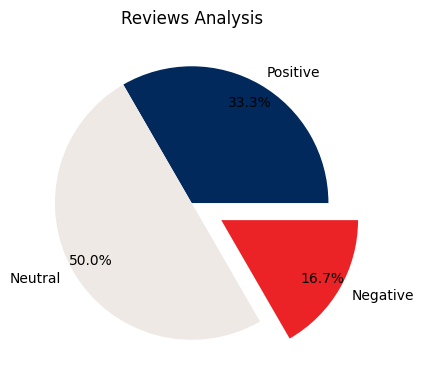

In [76]:
import matplotlib.pyplot as plt
import pandas as pd

# Example data (replace this with your actual data)
vader_counts = pd.Series([100, 150, 50], index=['Positive', 'Neutral', 'Negative'])

# Define the colors for the pie chart
colors = ['#01295c', '#efe9e5', '#eb2226']

# Define explode to separate the "Negative" slice
explode = (0, 0, 0.25)  # Only the "Negative" slice will be separated

plt.figure(figsize=(15, 7))

plt.subplot(1, 3, 2)
plt.title("Reviews Analysis")

# Plot pie chart
plt.pie(
    vader_counts.values,
    labels=vader_counts.index,
    explode=explode,  # Explode the "Negative" slice
    autopct='%1.1f%%',
    shadow=False,
    colors=colors,  # Use the custom color palette
    pctdistance=0.85,  # Distance of percentage labels from the center
    labeldistance=1.1  # Distance of labels from the center
)

plt.show()



In [77]:
df.to_csv("BA_reviews.csv")

## Wordcloud

Word Cloud or Tag Clouds is a visualization technique for texts that are natively used for visualizing the tags or keywords from the websites

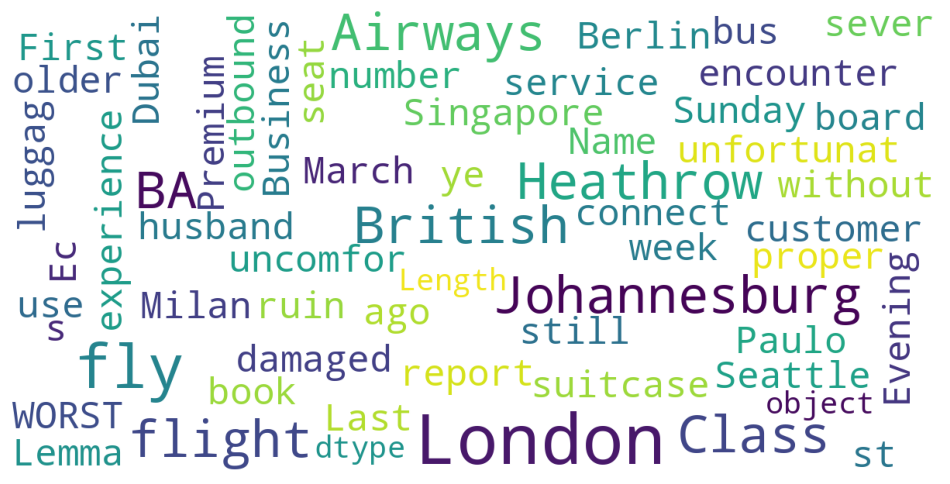

In [78]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df.Lemma)